# Classical Gym

尝试用Q-Learning算法，在`gym`中完成传统任务的学习。
- 熟悉`gym`环境
- 实现Q-Learning算法
- 应用于`CartPole-v1`任务

In [1]:
%pip install -U "gymnasium[classic_control]"

Note: you may need to restart the kernel to use updated packages.


`ShowEnv`类是用于在notebook动态显示动画过程的小工具。

In [3]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import numpy as np


class ShowEnv:
    def __init__(self):
        plt.ioff()
        self.fig, self.ax = plt.subplots()
        plt.close(self.fig)  # prevent repeating
        self.display = display.display(display.Pretty(""), display_id=True)

    def show(self, env):
        self.env = env
        self.img = self.ax.imshow(self.env.render())
        self.text = self.ax.text(0.5, 0.5, "", fontsize=20, backgroundcolor="white")
        self.display.update(self.fig)

    def update(self, text=""):
        data = self.env.render()
        self.img.set_data(data) # just update the data
        self.text.set_text(str(text))
        self.display.update(self.fig)

    def plot(self, *args, **kwargs):
        self.ax.plot(*args, **kwargs)
        self.display.update(self.fig)

## 熟悉`gym`环境和`CartPole`任务

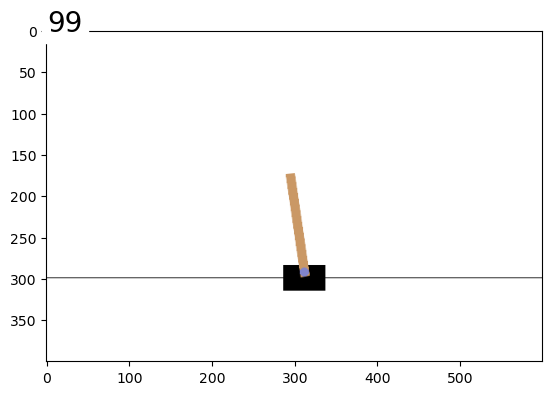

In [5]:
import gymnasium as gym

show = ShowEnv()

env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, _ = env.reset()
show.show(env)

try:
    for t in range(100):
        action = env.action_space.sample() # your agent here (this takes random actions)
        observation, reward, terminated, truncated, info = env.step(action)
        show.update(f"{t}")

        if terminated or truncated:
            observation = env.reset()
except KeyboardInterrupt:
    pass

env.close()

## CartPole-v1

### Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
### Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
### Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
### Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
### Reward:
        Reward is 1 for every step taken, including the termination step
### Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
### Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.

## 实现Q-Learning算法

### 设置参数

In [6]:
epsilon = 0.1
alpha = 0.1
gamma = 0.9
episodes = 500

actions = [0, 1]
max_steps = 200

### 初始化Q Table为字典

In [9]:
Q = {}

### 实现Q Learning中Q Table更新方法

- 根据公式
    Q(s,𝑎) ← Q(s,𝑎) + 𝛼[𝑟(𝑡) + 𝛾 max_{𝑎_{𝑡+1}} (Q(𝑠_{𝑡+1},𝑎_{𝑡+1})) − Q(s,𝑎)]
    更新Q Table中的值
- 注意处理Q Table中空值时的边界：
    - 当前state和action？
    - 下一状state和选择的action？

In [11]:
def learn(state, action, reward, next_state):
    # YOUR CODE HERE
    q_old = Q.get((state, action), reward)
    next_q = max(Q.get((next_state, a), reward) for a in actions)
    Q[(state, action)] = q_old + alpha * (reward + gamma * next_q - q_old)

### 实现Q-Learning中动作选择方法

- 区分探索和利用两种情况
- 获取Q Table中的值时，注意处理Q Table中空值时的边界
- 如果所有值都一样，随机选择一个
- * 一周目后可以尝试一个更优化的探索方法：max (q + random~N(0, qmax))

In [13]:
def choose_action(state, epsilon):
    # YOUR CODE HERE
    q = np.array([Q.get((state, a), 0) for a in actions], dtype=np.double) # 获得当前状态的Q值
    if np.random.rand() < epsilon:
        q += np.random.rand(len(actions)) * q.max()
    
    candidates, *_ = (q == q.max()).nonzero() # 获得最大Q值的动作
    i = np.random.choice(candidates) # 随机选择一个最大Q值的动作
    return actions[i]

### 实现将状态量化为离散值的方法

In [15]:
def quantilize(observation):
    pos, vel, ang, ang_vel = observation
    pos = np.digitize(pos, bins=np.linspace(-2.4, 2.4, num=10))
    vel = np.digitize(vel, bins=np.linspace(-3.5, 3.5, num=10))
    ang = np.digitize(ang, bins=np.linspace(-0.5, 0.5, num=10))
    ang_vel = np.digitize(ang_vel, bins=np.linspace(-3, 3, num=10))
    return pos, vel, ang, ang_vel

### 实现Q-Learning算法主体

- 循环500次在`CartPole-v1`任务中训练
- 每次训练包含一个最多200步的尝试
    - 获得环境状态
    - 选取动作
    - 获得新状态，如果已经失败，reward置为-100
    - 更新Q Table


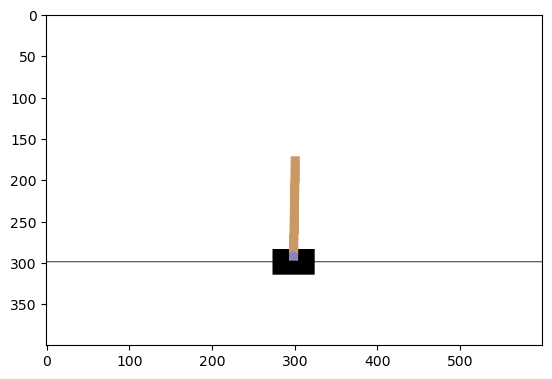

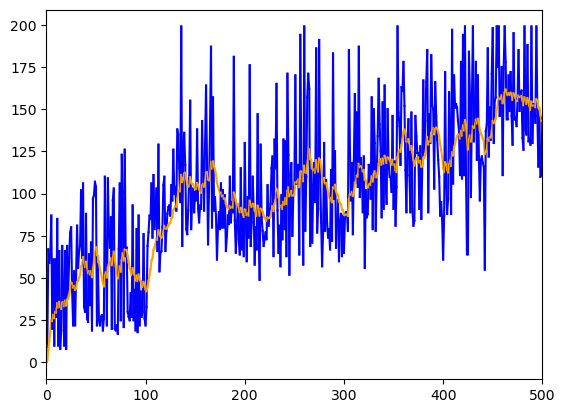

Episode 0 finished after 14 timesteps with reward 14.0
Episode 1 finished after 68 timesteps with reward 68.0
Episode 2 finished after 60 timesteps with reward 60.0
Episode 3 finished after 65 timesteps with reward 65.0
Episode 4 finished after 88 timesteps with reward 88.0
Episode 5 finished after 21 timesteps with reward 21.0
Episode 6 finished after 62 timesteps with reward 62.0
Episode 7 finished after 11 timesteps with reward 11.0
Episode 8 finished after 62 timesteps with reward 62.0
Episode 9 finished after 28 timesteps with reward 28.0
Episode 10 finished after 86 timesteps with reward 86.0
Episode 11 finished after 11 timesteps with reward 11.0
Episode 12 finished after 67 timesteps with reward 67.0
Episode 13 finished after 9 timesteps with reward 9.0
Episode 14 finished after 20 timesteps with reward 20.0
Episode 15 finished after 70 timesteps with reward 70.0
Episode 16 finished after 41 timesteps with reward 41.0
Episode 17 finished after 11 timesteps with reward 11.0
Epis

In [17]:
import gymnasium as gym

showenv = ShowEnv()
showplot = ShowEnv()
showplot.ax.set_xlim(0, episodes)

env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, _ = env.reset()
showenv.show(env)

last_t = 0
last_avg_t = 0
for episode in range(episodes):
    observation, _ = env.reset()
    total_reward = 0
    for t in range(max_steps):
        # YOUR CODE HERE
        state = quantilize(observation)
        action = choose_action(state, epsilon)
        next_observation, reward, terminated, truncated, info = env.step(action)
        next_state = quantilize(next_observation)
        learn(state, action, reward, next_state)
        observation = next_observation
        total_reward += reward
        # toggle the below comment to show live rendering
        # showenv.update(f"{t}")

        if terminated:
            # additional penalty for terminating
            learn(state, action, -100, next_state)
            break

    print(f"Episode {episode} finished after {t + 1} timesteps with reward {total_reward}")
    showplot.plot([episode, episode + 1], [last_t, t], "blue")
    avg_t = last_avg_t * 0.9 + t * 0.1
    showplot.plot([episode, episode + 1], [last_avg_t, avg_t], "orange")
    last_t = t
    last_avg_t = avg_t

env.close()

训练示例：
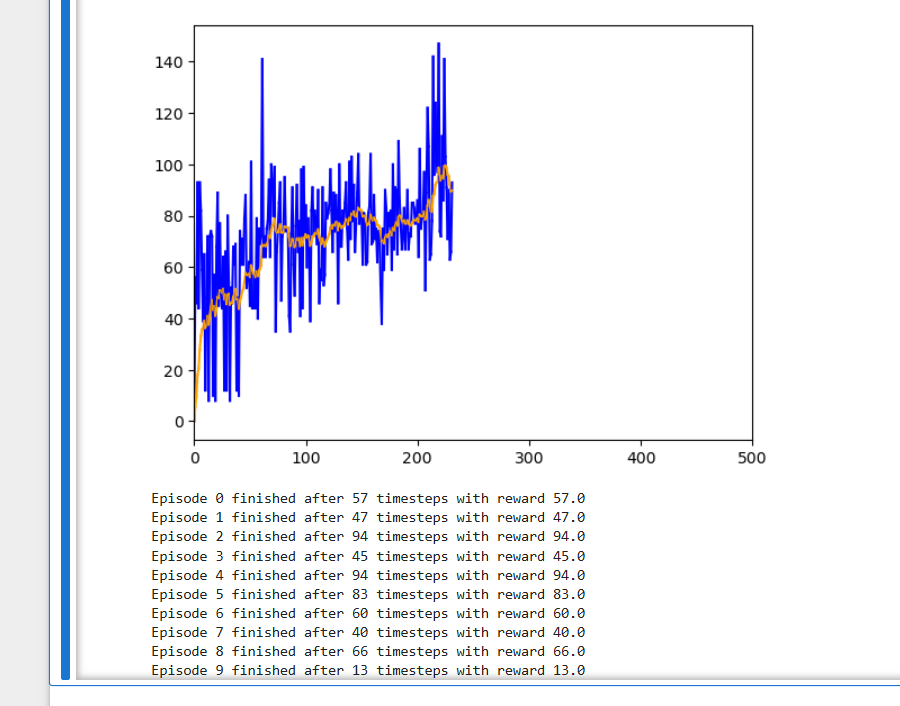






## 应用学好的策略操作`CartPole-v1`

用学好的策略操作替代随机策略，看看效果如何。

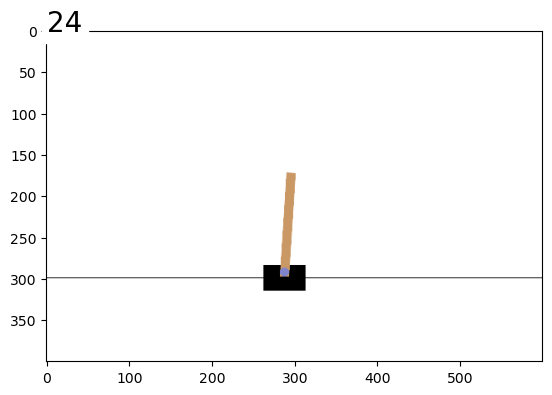

Episode 499 finished after 175 timesteps with reward 175.0
Episode 499 finished after 109 timesteps with reward 109.0
Episode 499 finished after 137 timesteps with reward 137.0
Episode 499 finished after 127 timesteps with reward 127.0
Episode 499 finished after 124 timesteps with reward 124.0
Episode 499 finished after 181 timesteps with reward 181.0
Episode 499 finished after 158 timesteps with reward 158.0
Episode 499 finished after 135 timesteps with reward 135.0
Episode 499 finished after 141 timesteps with reward 141.0
Episode 499 finished after 126 timesteps with reward 126.0
Episode 499 finished after 155 timesteps with reward 155.0
Episode 499 finished after 110 timesteps with reward 110.0
Episode 499 finished after 146 timesteps with reward 146.0
Episode 499 finished after 140 timesteps with reward 140.0
Episode 499 finished after 151 timesteps with reward 151.0


In [19]:
from itertools import count
import gymnasium as gym

show = ShowEnv()

with gym.make("CartPole-v1", render_mode="rgb_array") as env:
    observation, _ = env.reset()
    show.show(env)

    try:
        while True:
            observation, _ = env.reset()
            total_reward = 0
            for t in count():
                state = quantilize(observation)
                action = choose_action(state, epsilon=0)
                observation, reward, terminated, truncated, info = env.step(action)
                total_reward += reward
                show.update(f"{t}")
                if terminated: # or truncated:
                    print(f"Episode {episode} finished after {t + 1} timesteps with reward {total_reward}")
                    break
    except KeyboardInterrupt:
        pass